In [ ]:
# !pip install mysql-connector-python statsmodels seaborn

In [1]:
from get_sdams_db import GetSdamsDB
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils
from albumentations.augmentations.transforms import Normalize
import torch
import torch.nn as nn
from skimage import io, transform
from PIL import Image
from albumentations import GaussNoise, IAAAdditiveGaussianNoise, Compose, OneOf, HorizontalFlip, ShiftScaleRotate
from albumentations.pytorch import ToTensor
from efficientnet_pytorch import EfficientNet
import sys
sys.path.append('/Data/FoodDetection/AI_OCR/Whatiswrong/')
sys.path.append('/Data/FoodDetection/AI_OCR/Scatter/')
import utils
import os

device = torch.device('cuda')
experiment_name = f'{utils.SaveDir_maker(base_model = "pd_clf", base_model_dir = "./models")}'

In [2]:
sql = 'SELECT PRPD_CONT, INPUT_PD_PTRN_CD FROM tb_sta_pd_dtls_20200821'
with GetSdamsDB() as dbCon:
    data = dbCon.getDataPD(sql)

## eda

In [3]:
# data.loc[void_ids]['PRPD_CONT'].apply(lambda x : list(x.split('\n')))

NameError: name 'void_ids' is not defined

In [ ]:
void_ids = data[data['INPUT_PD_PTRN_CD']=='Void'].index
noise_ids = data[data['INPUT_PD_PTRN_CD']=='Noise'].index
surface_ids = data[data['INPUT_PD_PTRN_CD']=='Surface'].index
corona_ids = data[data['INPUT_PD_PTRN_CD']=='Corona'].index

void_iter = iter(void_ids)
noise_iter = iter(noise_ids)
surface_iter = iter(surface_ids)
corona_iter = iter(corona_ids)

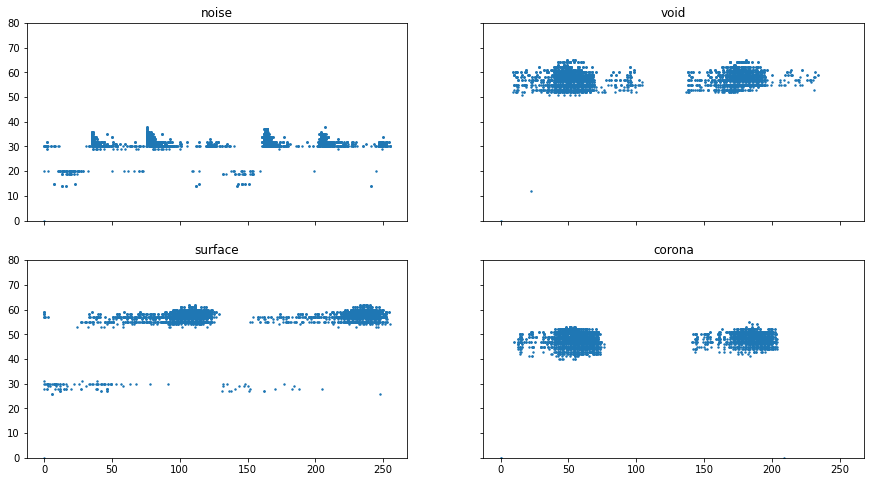

In [256]:
void_idx = next(void_iter)
noise_idx = next(noise_iter)
surface_idx = next(surface_iter)
# corona_idx = next(corona_iter)

fig, (x1, x2) = plt.subplots(2,2, figsize=(15,8), sharex=True, sharey=True)

x1[0].scatter(np.array(dataset[noise_idx])[:,3], np.array(dataset[noise_idx])[:,2], s=2)
x1[0].set_title('noise')
x1[1].set_ylim([0,80])
x1[1].scatter(np.array(dataset[void_idx])[:,3], np.array(dataset[void_idx])[:,2], s=2)
x1[1].set_title('void')
x2[0].scatter(np.array(dataset[surface_idx])[:,3], np.array(dataset[surface_idx])[:,2], s=2 )
x2[0].set_title('surface')
x2[1].scatter(np.array(dataset[corona_idx])[:,3], np.array(dataset[corona_idx])[:,2], s=2)
x2[1].set_title('corona')
plt.show()

## clf

In [3]:
data['label'] = data['INPUT_PD_PTRN_CD'].apply(lambda x : 1 if x!='Noise' else 0)

In [4]:
noise = data[data['label']==0][['PRPD_CONT', 'label']]
pd = data[data['label']==1][['PRPD_CONT', 'label']]

In [5]:
def Get_coord(a):
    a = a['PRPD_CONT'].apply(lambda x : x.split('\n'))

    dataset = []
    for row in tqdm(a):
        rows = []
        for idx, event in enumerate(row[1:]):
    #         print(event)
            if event=='':
                continue
            rows.append(list(np.asarray(event.split(',')).astype(int))[2:])
        dataset.append(rows)
    return dataset

In [6]:
pd_coord = Get_coord(pd)
nz_coord = Get_coord(noise)

100%|██████████| 2444/2444 [01:13<00:00, 53.23it/s]


In [7]:
def Dataset_with_Label(data, label):
    dataset_with_label = []
    for i in range(len(data)):
        dataset_with_label.append([data[i], label])
    return dataset_with_label

In [8]:
pd_dataset = Dataset_with_Label(pd_coord, 1)
nz_dataset = Dataset_with_Label(nz_coord, 0)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


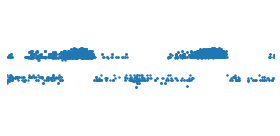

In [10]:
idx = 0
fig = plt.figure(figsize=(4,2))
plt.ylim(0,80)
plt.xlim(0, 254)
# plt.axes().axis('off')
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.axes().set_frame_on(False)
plt.tight_layout()
plt.scatter(x = np.asarray(pd_dataset[idx][0])[:,1], y = np.asarray(pd_dataset[idx][0])[:,0], s=2 )

In [9]:
print(len(nz_dataset))
print(len(pd_dataset))

2444
322


### augmentation

In [10]:
class Custom_dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.tensor =  ToTensor()
        self.normalize = Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        point_coord, label = self.dataset[idx]
        
        # plotting
        fig = plt.figure(figsize=(4,2))
        plt.ylim(0,80)
        plt.xlim(0, 254)
#         plt.axes().axis('off')
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        plt.axes().set_frame_on(False)
        plt.tight_layout()
        plt.scatter(x = np.asarray(point_coord)[:,1], y = np.asarray(point_coord)[:,0], s=2 )
        plt.close()
        
        # convert to array
        fig.canvas.draw()
        img_arr = np.array(fig.canvas.renderer._renderer)[:, :, :3]
#         img_arr = img_arr[:,:, np.newaxis] / 255
#         img_arr = img_arr/255
        img_arr = self.normalize(**{'image' : img_arr})['image']
        
        if self.transform:
            return (self.transform(**{'image' : img_arr})['image'], label)
            
        else:
            return (self.tensor(**{'image' : img_arr})['image'], label)

In [11]:
transformers = Compose([OneOf([
                            HorizontalFlip(p=0.5), 
                            ShiftScaleRotate(rotate_limit = 0, scale_limit = 0.01, shift_limit=0.3, p=0.5)
                            ]),
                        ToTensor() 
                       ])

In [12]:
pd_train = pd_dataset[ : int(len(pd_dataset) * 0.9)]
pd_valid = pd_dataset[int(len(pd_dataset) * 0.9) : ]

nz_train = nz_dataset[ : int(len(nz_dataset) * 0.9)]
nz_valid = nz_dataset[int(len(nz_dataset) * 0.9) : ]

In [13]:
print('before extend : ',len(nz_valid))
nz_valid.extend(pd_valid)
print('after extend : ',len(nz_valid))

before extend :  245
after extend :  278


In [ ]:
batch_size = 128
epoch = 5
grad_clip = 5

pd_custom = Custom_dataset(pd_train, transform=transformers)
nz_custom = Custom_dataset(nz_train, transform=transformers)
valid_custom = Custom_dataset(nz_valid)

pd_sampler = torch.utils.data.RandomSampler(pd_custom, True, int(max(len(pd_custom), len(nz_custom)))*(epoch))
nz_sampler = torch.utils.data.RandomSampler(nz_custom, True, int(max(len(pd_custom), len(nz_custom)))*(epoch))

pd_loader = DataLoader(pd_custom, batch_size = batch_size, sampler=pd_sampler,  pin_memory=True)
nz_loader = DataLoader(nz_custom, batch_size = batch_size, sampler=nz_sampler,  pin_memory=True)
valid_loader = DataLoader(valid_custom, batch_size = batch_size, shuffle=True, pin_memory=True)

pd_iter = iter(pd_loader)
nz_iter = iter(nz_loader)
valid_iter = iter(valid_loader)

iter_per_epoch = len(pd_loader)//epoch

In [ ]:
iterer= iter(pd_loader)
img_arr, label = next(iterer)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


## model

In [ ]:
# model = EfficientNet.from_name('efficientnet-b0', override_params={'num_classes' : 1})

In [103]:
# res = model(img_arr)

In [113]:
criterion = torch.nn.BCEWithLogitsLoss()
criterion(res.squeeze(1), label.type(torch.FloatTensor))

In [40]:
# img, label = next(valid_iter)

## train

In [ ]:
os.makedirs(f'./models/{experiment_name}', exist_ok=True)


model = EfficientNet.from_name('efficientnet-b0', override_params={'num_classes' : 1})
model = model.to(device)

#data parallel for multi GPU
model = torch.nn.DataParallel(model).to(device)
model.train() 

# loss
criterion = torch.nn.BCEWithLogitsLoss().to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)

# filter that only require gradient descent
filtered_parameters = []
params_num = []
for p in filter(lambda p : p.requires_grad, model.parameters()):
    filtered_parameters.append(p)
    params_num.append(np.prod(p.size()))
print('Tranable params : ', sum(params_num))

#optimizer
# optimizer = torch.optim.AdamW(filtered_parameters)
optimizer = torch.optim.Adadelta(filtered_parameters)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', verbose=True, patience = 2, factor= 0.5 )

# log
with open(f'./models/{experiment_name}/opt.txt', 'a') as opt_file:
    opt_log = '---------------------Options-----------------\n'
    opt_log +=f'batch size : {batch_size}\n'
    opt_log +=f'epoch : {epoch}\n'
    opt_log +='---------------------------------------------\n'
    opt_file.write(opt_log)

best_accuracy = 0
for epoc in range(epoch):
    for step in range(iter_per_epoch):

        if step%2==0:
            img, label = next(pd_iter)
        else:
            img, label = next(nz_iter)

        img = img.to(device)
#         label = label.to(device)
        logit = model(img)
        
        loss = criterion(logit.squeeze(1), label.type(torch.FloatTensor).to(device))
        loss_avg = utils.Averager()
        loss_avg.add(loss)

        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        print(loss_avg.val())

    #validation
    valid_iter = iter(valid_loader)
    valid_loss_avg = utils.Averager()
    batch_acc = 0
    with open(f'./models/{experiment_name}/log_train.txt', 'a') as log:
        model.eval()
        with torch.no_grad():
            for val_step in range(len(valid_iter)):

                img, label = next(valid_iter)
                img = img.to(device)
                each_batch_size = img.size(0)

                logit = model(img)
                val_loss = criterion(logit, label.type(torch.FloatTensor).to(device))
                valid_loss_avg.add(val_loss)

                pred = torch.where(torch.sigmoid(logit) > 0.5, torch.Tensor([1]).to(device), torch.Tensor([0]).to(device))
#                 _, pred = logit.max(1)
                print('logit : ', logit.squeeze(1))
                print('pred : ', pred)
                print('label : ', label)
                batch_true = torch.sum(pred == label.reshape(each_batch_size, 1).to(device)).item()

                batch_acc += (batch_true/each_batch_size)
#             print(batch_acc)
        
        valid_acc = batch_acc / len(valid_iter)
        model.train()
        loss_log = f'[epoch : {epoc}/{epoch}]\nTrain loss : {loss_avg.val():0.5f}, valid loss : {valid_loss_avg.val():0.5f}'            
        valid_log = f'{"current accuracy":17s} : {valid_acc:0.3f}'
        best_model_log = f'{"Best accuracy":17s}: {best_accuracy:0.3f}'
        loss_model_log = f'{loss_log}\n{valid_log}\n{best_model_log}\n{"-"*80}'
        log.write(loss_model_log+'\n')
    if best_accuracy < valid_acc :
        best_accuracy = valid_acc
        torch.save(model.module.state_dict(), f'./models/{experiment_name}/best_accuracy_{round(best_accuracy,2)}.pth')
        
        

Tranable params :  4008829
tensor(0.7512, device='cuda:0')
tensor(1.2313, device='cuda:0')
tensor(0.9811, device='cuda:0')
tensor(1.2104, device='cuda:0')
tensor(0.9430, device='cuda:0')
tensor(1.1529, device='cuda:0')
tensor(0.9529, device='cuda:0')
tensor(1.0707, device='cuda:0')
tensor(0.8977, device='cuda:0')
tensor(0.9400, device='cuda:0')
tensor(0.9542, device='cuda:0')
tensor(0.9472, device='cuda:0')


In [25]:
label.shape

torch.Size([128])

In [735]:
valid_iter = iter(valid_loader)

In [ ]:
img, label = next(valid_iter)
img = img.to(device)
logit = model(img)
pred = torch.where(torch.sigmoid(logit) > 0.5, torch.Tensor([1]).to(device), torch.Tensor([0]).to(device))
pred.squeeze(1)

In [728]:
label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [714]:
torch.sum(pred == label.reshape(batch_size, 1).to(device)).item()

20

In [715]:
torch.sum(pred == label.reshape(each_batch_size, 1).to(device)).item()

RuntimeError: shape '[18, 1]' is invalid for input of size 20

In [98]:
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
output

tensor(1.4390, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [96]:
input.shape

torch.Size([3])

In [119]:
input

tensor([ 0.5367, -2.1753, -1.3417], requires_grad=True)

In [120]:
target

tensor([1., 1., 1.])

In [100]:
target.shape

torch.Size([3])

In [734]:
torch.where(torch.Tensor(logit) > 0.5, torch.Tensor([1]), torch.Tensor([0]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

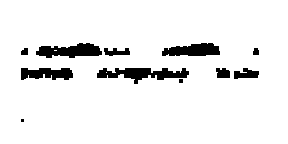

In [316]:
# shift and scale
Image.fromarray((img_arr[0].permute(1,2,0).squeeze(2).numpy().astype(np.uint8) * 255))

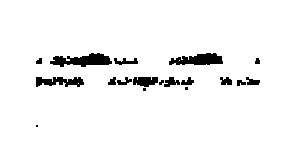

In [312]:
# horizon flip
Image.fromarray((img_arr[0].permute(1,2,0).squeeze(2).numpy().astype(np.uint8) * 255))

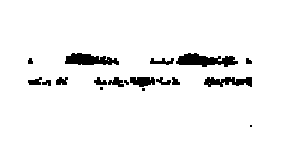

In [302]:
# normal
Image.fromarray((img_arr[0].permute(1,2,0).squeeze(2).numpy().astype(np.uint8) * 255))